# BERT Classification Modeling  -KERAS
### @Author : Woojin Park, Nidhi Bhaskar
### @Copyright : 2020, Neolth NSF grant NLP project 
### @Email : woojinpa@andrew.cmu.edu , nidhibha@andrew.cmu.edu
### @Status : In-Progress

##### @article{turc2019,title={Well-Read Students Learn Better: On the Importance of Pre-training Compact Models}, author={Turc, Iulia and Chang, Ming-Wei and Lee, Kenton and Toutanova, Kristina}, journal={arXiv preprintarXiv:1908.08962v2 },year={2019}}



In [3]:
### Import Relevant Libraries
import os
import pandas as pd
import numpy as np
import collections
import datetime as dt
import requests
import json
import re
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from scipy.stats import norm
from IPython.display import display, Image

import string
import re
import nltk
from nltk.util import ngrams
from nltk import pos_tag,word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split



In [2]:
### Build a get_date function to convert date format
#### Build a data_creation function to read json data into pandas dataframe

def get_date(created):
    return dt.datetime.fromtimestamp(created)

def data_creation(subreddit) : 
    with open('submissions_'+subreddit+'.json') as f:
        data = json.loads("[" + 
            f.read().replace("}\n{", "},\n{") + 
        "]")
    data =pd.DataFrame(data)
    reddit_data = data[['author','over_18','title','selftext','num_comments', 'score', 'full_link','created_utc']]
    reddit_data = reddit_data.dropna()
    _timestamp = reddit_data["created_utc"].apply(get_date)
    reddit_data = reddit_data.assign(timestamp = _timestamp)
    reddit_data['over_18'] = reddit_data['over_18'].astype('str')
    reddit_data['subreddit']= subreddit
    # Build column have title + selftext
    reddit_data['title_with_selftext']= reddit_data['title'] +" " + reddit_data['selftext']

    # Do one more extra cleaning : keep updating this part
    reddit_data=reddit_data[~reddit_data['title_with_selftext'].isin([ '[removed]', '[deleted]',''])]
    subreddit = reddit_data    
    return subreddit

def empty_words_clean(text):
    text = text.replace('[removed]','')
    text= text.replace('[deleted]','')
    text= text.replace('\n','')
    return (text)

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [5]:
#### 0: SuicideWatch 0.8
#### 1 : depressed
#### 2 : happy 0.9
#### 3 :  selfimprovement 0.9



### Dataframing 4 subreddit Datasets
SuicideWatch_df = data_creation('SuicideWatch')
depressed_df = data_creation('depressed')
happy_df = data_creation('happy')
selfimprovement_df = data_creation('selfimprovement')


SuicideWatch_df = SuicideWatch_df.sample(frac=0.8, replace=True, random_state=1)
depressed_df = depressed_df.sample(frac=0.99, replace=True, random_state=1)
happy_df = happy_df.sample(frac=0.9, replace=True, random_state=1)
selfimprovement_df = selfimprovement_df.sample(frac=0.9, replace=True, random_state=1)



### Concat all 4 dataframes into one merged file
all_subreddit_df = pd.concat([SuicideWatch_df,depressed_df,happy_df,selfimprovement_df])

In [6]:
### 0.Data Preparation

In [7]:
#### Text Preprocessing by following pipeline : 
### Raw text => Tokeninze/lowercase => Remove stop words => Remove non-alphabetic characters => 
### Remove Extra Punctuations => Lemmatization => Build Custom Stop words dictionary 

In [8]:
# Build function that takes a word and returns true if it consists only of non-alphabetic characters
def alpha_filter(w):
    pattern = re.compile('^[^a-z]+$')
    if (pattern.match(w)):
        return True
    else:
        return False
    
# Build data preparation function including all the necessary 7 steps :
def clean_words(text):
    # lower text & tokenizing
    text = text.replace('\n',' ')
    text = text.replace('[removed]',' ')
    text= text.replace('[deleted]', '')
    text =text.lower()
    
    ### Updated cleaning-pipeline : 
    text = re.sub(r'[^a-zA-Z0-9 ]',r' ',text) #remove anything that is not a letter or number first
    text = [word for word in text.split(" ")]
    
    # remove stop words
    nltk_stopwords = set(stopwords.words('english'))
    review_lower_stop = [x for x in text if not x in nltk_stopwords]
    # remove extra punctuations
    review_lower_stop_pun = [y for y in review_lower_stop if not alpha_filter(y)]
    review_lower_stop_pun_extra = [''.join(x for x in par if x not in string.punctuation) for par in review_lower_stop_pun]
    # Lemmatization
    porter = WordNetLemmatizer()
    review_lower_stop_pun_extra_lemmatized = []
    for a in review_lower_stop_pun_extra : 
        review_lower_stop_pun_extra_lemmatized.append(porter.lemmatize(a))
    # buid custom stop words dictionary
    cachedStopWords = set(stopwords.words("english"))

    ####Keep Updating custom stop words
    cachedStopWords.update(('nt', 'wo', 're', 'im', 'yall','u','ca','ive', 'wan','na','gon','nov','x200b','amp',\
                        'wwwyoutubecomwatch','http','vbjkbl5olvm8','lt', 'br', 'gt', 'amp','tsp','tbsp','nbsp'))   
    review_lower_stop_pun_extra_lemmatized_stop = [x for x in review_lower_stop_pun_extra_lemmatized\
                                                   if not x in cachedStopWords]
    text = " ".join(review_lower_stop_pun_extra_lemmatized_stop)
    return (text)

def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

In [9]:
##Data Sampling

In [10]:
### Because of relatively huge dataset, we need to perform random sampling of 30% for now

all_subreddit_df_list = all_subreddit_df.sample(frac=0.3, replace=True, random_state=1)

In [11]:
all_subreddit_df_list["title_with_selftext_clean"] = all_subreddit_df_list["title_with_selftext"].apply(lambda x: clean_words(x))

In [12]:
all_subreddit_df_list['polarity'] = all_subreddit_df_list['title_with_selftext_clean'].apply(detect_polarity)

In [13]:
all_subreddit_df_list.head(3)

author over_18  \
12970           sudrawkid   False   
5192          PinkyIsSnug   False   
2357   ReasonableBrother3   False   

                                                   title  \
12970  Can't properly stick up for myself and feel weak.   
5192   Gonna kill myself very very soon. I've really ...   
2357                               GET RID OF DEPRESSION   

                                                selftext  num_comments  score  \
12970  Hey everyone! I guess I should just outright g...             2      4   
5192   I joined this school with high hopes. hopes th...             5      1   
2357                                           [removed]             0      1   

                                               full_link  created_utc  \
12970  https://www.reddit.com/r/selfimprovement/comme...   1533443455   
5192   https://www.reddit.com/r/SuicideWatch/comments...   1580935590   
2357   https://www.reddit.com/r/depressed/comments/g0...   1586839925   

                timestamp        subreddit  \
12970 2018-08-05 00:30:55  selfimprovement   
5192  2020-02-05 15:46:30     SuicideWatch   
2357  2020-04-14 00:52:05        depressed   

                                     title_with_selftext  \
12970  Can't properly stick up for myself and feel we...   
5192   Gonna kill myself very very soon. I've really ...   
2357                     GET RID OF DEPRESSION [removed]   

                               title_with_selftext_clean  polarity  
12970  properly stick feel weak  hey everyone  guess ... -0.116927  
5192   gonna kill soon  really tried year tipping poi... -0.028633  
2357                                get rid depression    0.000000

In [14]:
#Descriptive statistics & dataframe  info

In [15]:
all_subreddit_df_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47828 entries, 12970 to 43513
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   author                     47828 non-null  object        
 1   over_18                    47828 non-null  object        
 2   title                      47828 non-null  object        
 3   selftext                   47828 non-null  object        
 4   num_comments               47828 non-null  int64         
 5   score                      47828 non-null  int64         
 6   full_link                  47828 non-null  object        
 7   created_utc                47828 non-null  int64         
 8   timestamp                  47828 non-null  datetime64[ns]
 9   subreddit                  47828 non-null  object        
 10  title_with_selftext        47828 non-null  object        
 11  title_with_selftext_clean  47828 non-null  object        
 12  

In [16]:
all_subreddit_df_list.describe()

num_comments         score   created_utc      polarity
count  47828.000000  47828.000000  4.782800e+04  47828.000000
mean       6.214289     65.042590  1.557714e+09      0.076999
std       28.489875    966.074055  3.417972e+07      0.254898
min        0.000000      0.000000  1.304697e+09     -1.000000
25%        1.000000      1.000000  1.538144e+09     -0.038462
50%        2.000000      1.000000  1.570949e+09      0.039981
75%        5.000000      3.000000  1.584263e+09      0.194731
max     1825.000000  81714.000000  1.590173e+09      1.000000

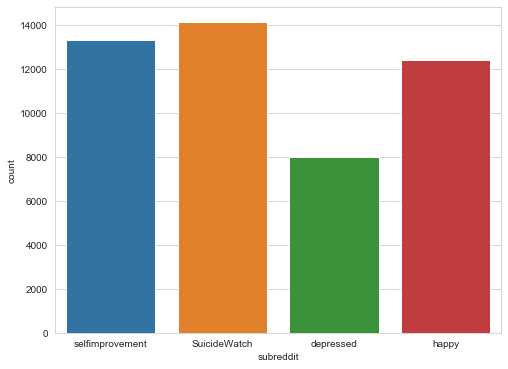

In [17]:
# Build Bar plot for all 4 subreddit distribution

plt.figure(figsize=(8,6))
sns.countplot(x='subreddit',data=all_subreddit_df_list)

In [18]:
## Polarity (Sentiment) distribution of all 4 subreddit - Symmetric/ not skewed

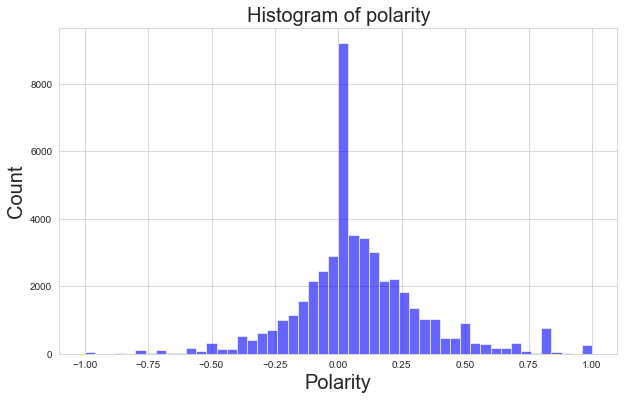

In [19]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(all_subreddit_df_list.polarity, num_bins, facecolor='blue', alpha=0.6)
plt.xlabel('Polarity',fontsize =20)
plt.ylabel('Count',fontsize =20)
plt.title('Histogram of polarity',fontsize =20)
plt.show()

In [20]:
### Build NMF Model

In [21]:
# get topics with their terms and weights
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights, sorted_indices)])
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])
    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]
    return topics

# prints components of all the topics  obtained from topic modeling
def print_topics_udf(topics, total_topics=4,
                     weight_threshold=0.0001,
                     display_weights=False,
                     num_terms=None):

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        if display_weights:
            print('Topic'+str(index)+' with weights : ')
            print(topic[:num_terms]) if num_terms else topic
            print('\n')
        else:
            print('Topic #'+str(index)+' without weights : ')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw

In [22]:

def tfidf_nmf_function (dataframe, no_top_words, number) :
# Store only text contents
    data_text = dataframe[['title_with_selftext_clean']]
    data_text['index'] = dataframe.index
    # Assign to 'documents' which has texts and index of each
    documents = data_text
    ## Vectorization
    # NMF is able to use tf-idf - vectorize the corpus
    tfidf_vectorizer = TfidfVectorizer(max_df=0.80, min_df=10, max_features=6000,ngram_range=(1, 2)
                                   ,stop_words='english', token_pattern = r'\b[^\d\W]+\b')
    
    ## min_df = 10 : ignore words that appear in less than 10 of the subreddits
    ##  max_df=0.80 : model to ignore words that appear in more than 80% of the subreddits
    ## max_features=6000 : After processing we have a little over 9k(9688) unique words 
    ### so we’ll set the max_features to only include the top 6k 
    #### by term frequency across the articles for further feature reduction.
    ##  ngram_range=(1, 2) : tf-idf weights for n-grams (bigrams, trigrams etc.). 
    ### To do that we’ll set the n_gram range to (1, 2) 
    #### which will include unigrams and bigrams.
    
    
    # calculate the feature matrix
    tfidf = tfidf_vectorizer.fit_transform(dataframe['title_with_selftext_clean'])
    print( "Created %d X %d TF-IDF-normalized document-term matrix" % (tfidf.shape[0], tfidf.shape[1]) )
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()


    print ( "in the corpus of N documents, total of N unique features :")
    display(tfidf.shape)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    print("Length of unique features are : ", len(tfidf_vectorizer.get_feature_names()))

    # Run NMF  
    nmf = NMF(n_components=number, random_state=1, alpha=.3, l1_ratio=.5, init='nndsvd')
    
    ### Regularization ? 
    ####will lower the variance from the model - More robust decision on data as it minimize overfitting
    ##  ‘nndsvd’  :Nonnegative Double Singular Value Decomposition which works best on sparse data like we have here
    ##  As in ElasticNet, we control the combination of L1 (Lasso) and L2 (Ridge) with the l1_ratio (ρ) parameter
    ###between 0< - <1  and the intensity of the regularization with the alpha (α) parameter
    
    nmf_z = nmf.fit_transform(tfidf)
    nmf_weights = nmf.components_
    nmf_feature_names = tfidf_vectorizer.get_feature_names()


    for topic_idx, topic in enumerate(nmf.components_):
            print("Topic %d:" % (topic_idx))
            print(", ".join([tfidf_feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]) ,"\n")
            
    topics = get_topics_terms_weights(nmf_weights, nmf_feature_names)
    print_topics_udf(topics, total_topics=4, num_terms=30, display_weights=True)

    TopicNumber=[]
    for i in range(len(nmf_z)):
        h=nmf_z[i].tolist().index(nmf_z[i].max())
        TopicNumber.append(h)
    documents['topic_nmf']=TopicNumber
    dataframe['topic_nmf'] =TopicNumber
    sns.countplot(x='topic_nmf', data=documents)
  

In [23]:
### We are having better results with NMF (over TF-IDF matrix) than with LDA. 
### The top keywords of the topics NFM finds are more related and meaningful to the context of my corpus, 
###which are posts of many subjects shared internally in my organization.

/Users/Jay/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Created 47828 X 6000 TF-IDF-normalized document-term matrix
in the corpus of N documents, total of N unique features :


(47828, 6000)

Length of unique features are :  6000
Topic 0:
life, time, year, friend, know, people, thing, day, really, think, like, help, going, work, make, got, good, school, love, job, need, thought, way, better, self, month, say, lot, family, person 

Topic 1:
happy, make happy, make, today, finally, feel happy, year, day, love, birthday, happy life, dog, really happy, happy happy, want happy, smile, family, happiness, happy birthday, christmas, picture, little, video, place, happy new, new, happy today, got, baby, girl 

Topic 2:
feel, like, feel like, feeling, know, make feel, really, make, people, dont, sad, anymore, know feel, want, depressed, like feel, thing, like shit, shit, hate, want feel, good, bad, life feel, talk, think, felt, feeling like, better, feel better 

Topic 3:
want, die, want die, kill, fucking, anymore, dont, hate, live, know, end, life, tired, pain, want kill, wish, care, dont want, hurt, fuck, want live, wanna, alive, suicide, want end, shit, stop, death, die want, sca

/Users/Jay/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


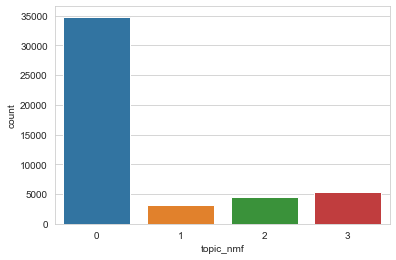

In [24]:
#def nmf_function (tfidf, model, feature_names, no_top_words) :
#nmf_function (tfidf,nmf, tfidf_feature_names, 20) 
#visualization topic distribution
tfidf_nmf_function(all_subreddit_df_list,30 ,4)

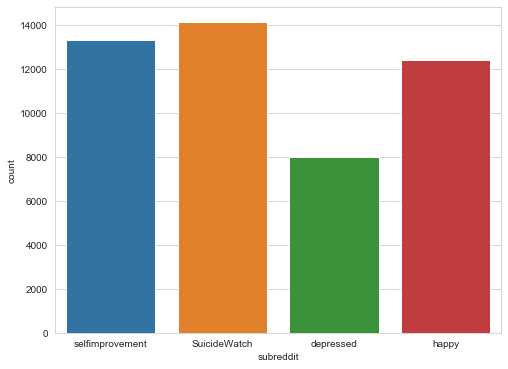

In [25]:
# Compare the Bar plot for all 4 subreddit distribution with above Topic modeling distribution
plt.figure(figsize=(8,6))
sns.countplot(x='subreddit',data=all_subreddit_df_list)

In [26]:
from collections import Counter 
print(Counter(all_subreddit_df_list.topic_nmf))

Counter({0: 34804, 3: 5328, 2: 4577, 1: 3119})


In [27]:
topic0_gr = all_subreddit_df_list[all_subreddit_df_list['topic_nmf'] ==0]
topic1_gr = all_subreddit_df_list[all_subreddit_df_list['topic_nmf'] ==1]
topic2_gr = all_subreddit_df_list[all_subreddit_df_list['topic_nmf'] ==2]
topic3_gr = all_subreddit_df_list[all_subreddit_df_list['topic_nmf'] ==3]

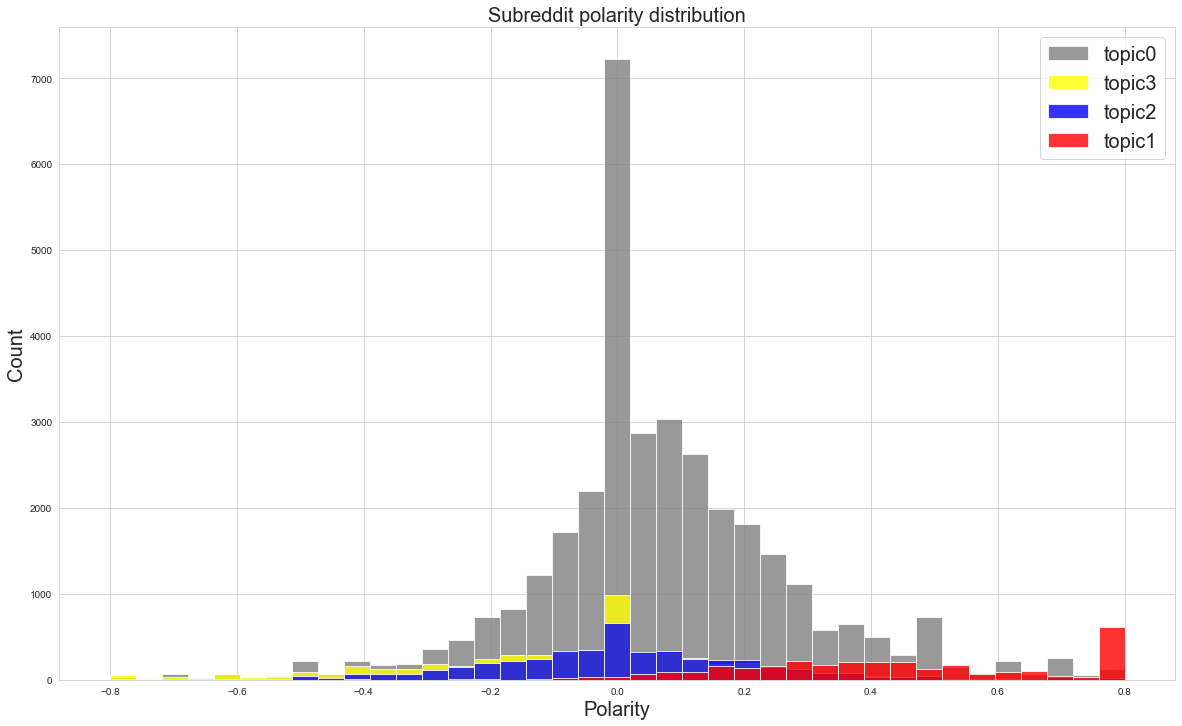

In [28]:
from matplotlib import pyplot
plt.figure(figsize=(20,12))
bins = np.linspace(-.8, .8, 40)

pyplot.hist(topic0_gr['polarity'], bins, alpha=0.8, label='topic0',color='grey')
pyplot.hist(topic3_gr['polarity'], bins, alpha=0.8, label='topic3',color='yellow')
pyplot.hist(topic2_gr['polarity'], bins, alpha=0.8, label='topic2',color='blue')
pyplot.hist(topic1_gr['polarity'], bins, alpha=0.8, label='topic1',color='red')

plt.xlabel('Polarity',fontsize =20)
plt.ylabel('Count',fontsize =20)
pyplot.legend(loc='upper right',fontsize=20)
plt.title('Subreddit polarity distribution',fontsize =20)

pyplot.show()

In [29]:
# Encoding subreddit into 'subreddit_categorical_label' -> To use this column in classification modeling
#### 0: SuicideWatch
#### 1 : depressed
#### 2 : happy
#### 3 :  selfimprovement

In [30]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(all_subreddit_df_list.subreddit)
all_subreddit_df_list['subreddit_categorical_label'] = le.transform(all_subreddit_df_list.subreddit)

In [31]:
all_subreddit_df_list.head(4)

author over_18  \
12970           sudrawkid   False   
5192          PinkyIsSnug   False   
2357   ReasonableBrother3   False   
35396      Pineapplestick   False   

                                                   title  \
12970  Can't properly stick up for myself and feel weak.   
5192   Gonna kill myself very very soon. I've really ...   
2357                               GET RID OF DEPRESSION   
35396                       I won my first boxing match!   

                                                selftext  num_comments  score  \
12970  Hey everyone! I guess I should just outright g...             2      4   
5192   I joined this school with high hopes. hopes th...             5      1   
2357                                           [removed]             0      1   
35396                                                                1      1   

                                               full_link  created_utc  \
12970  https://www.reddit.com/r/selfimprovement/comme...   1533443455   
5192   https://www.reddit.com/r/SuicideWatch/comments...   1580935590   
2357   https://www.reddit.com/r/depressed/comments/g0...   1586839925   
35396  https://www.reddit.com/r/happy/comments/ea4lxo...   1576247068   

                timestamp        subreddit  \
12970 2018-08-05 00:30:55  selfimprovement   
5192  2020-02-05 15:46:30     SuicideWatch   
2357  2020-04-14 00:52:05        depressed   
35396 2019-12-13 09:24:28            happy   

                                     title_with_selftext  \
12970  Can't properly stick up for myself and feel we...   
5192   Gonna kill myself very very soon. I've really ...   
2357                     GET RID OF DEPRESSION [removed]   
35396                      I won my first boxing match!    

                               title_with_selftext_clean  polarity  topic_nmf  \
12970  properly stick feel weak  hey everyone  guess ... -0.116927          0   
5192   gonna kill soon  really tried year tipping poi... -0.028633          0   
2357                                get rid depression    0.000000          0   
35396                               first boxing match    0.250000          0   

       subreddit_categorical_label  
12970                            3  
5192                             0  
2357                             1  
35396                            2

In [32]:
## descriptive statistics after topic modeling

In [33]:
all_subreddit_df_list.describe(include ='all').transpose()

count unique  \
author                       47828  30841   
over_18                      47828      2   
title                        47828  38485   
selftext                     47828  27149   
num_comments                 47828    NaN   
score                        47828    NaN   
full_link                    47828  40246   
created_utc                  47828    NaN   
timestamp                    47828  40220   
subreddit                    47828      4   
title_with_selftext          47828  40074   
title_with_selftext_clean    47828  39823   
polarity                     47828    NaN   
topic_nmf                    47828    NaN   
subreddit_categorical_label  47828    NaN   

                                                                           top  \
author                                                               [deleted]   
over_18                                                                  False   
title                                                                     Help   
selftext                                                                         
num_comments                                                               NaN   
score                                                                      NaN   
full_link                    https://www.reddit.com/r/depressed/comments/dq...   
created_utc                                                                NaN   
timestamp                                                  2019-11-02 23:41:15   
subreddit                                                         SuicideWatch   
title_with_selftext                              I can’t stop crying [removed]   
title_with_selftext_clean                                                        
polarity                                                                   NaN   
topic_nmf                                                                  NaN   
subreddit_categorical_label                                                NaN   

                              freq               first                last  \
author                        2043                 NaT                 NaT   
over_18                      47721                 NaT                 NaT   
title                           83                 NaT                 NaT   
selftext                      9901                 NaT                 NaT   
num_comments                   NaN                 NaT                 NaT   
score                          NaN                 NaT                 NaT   
full_link                        8                 NaT                 NaT   
created_utc                    NaN                 NaT                 NaT   
timestamp                        8 2011-05-06 11:43:50 2020-05-22 14:39:15   
subreddit                    14124                 NaT                 NaT   
title_with_selftext             19                 NaT                 NaT   
title_with_selftext_clean       25                 NaT                 NaT   
polarity                       NaN                 NaT                 NaT   
topic_nmf                      NaN                 NaT                 NaT   
subreddit_categorical_label    NaN                 NaT                 NaT   

                                    mean          std         min  \
author                               NaN          NaN         NaN   
over_18                              NaN          NaN         NaN   
title                                NaN          NaN         NaN   
selftext                             NaN          NaN         NaN   
num_comments                     6.21429      28.4899           0   
score                            65.0426      966.074           0   
full_link                            NaN          NaN         NaN   
created_utc                  1.55771e+09  3.41797e+07  1.3047e+09   
timestamp                            NaN          NaN         NaN   
subreddit                            NaN          NaN   

In [ ]:
#Download to csv file for google colab
all_subreddit_df_list.to_csv("all_subreddit_df_list.csv")

In [5]:
all_subreddit_df_list = pd.read_csv('all_subreddit_df_list_new.csv' ,encoding='utf-8')

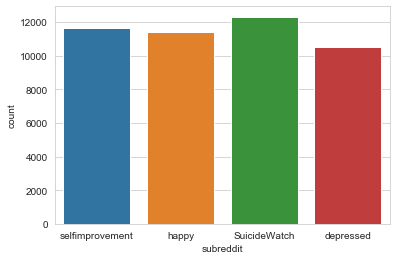

In [6]:
import seaborn as sns
sns.countplot(x=all_subreddit_df_list['subreddit'])

## Begin BERT Modeling : 

In [3]:
print(keras.__version__)

2.2.4


In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
from bert import modeling
from tensorflow import keras
import codecs
import tensorflow as tf
from tqdm import tqdm

from chardet import detect
import keras
from keras_radam import RAdam
from keras import backend as K
from keras_bert import load_trained_model_from_checkpoint
from keras_bert import get_base_dict, get_model, compile_model, gen_batch_inputs
import codecs
from keras_bert import Tokenizer
#!pip install keras-bert
#!pip install keras-rectified-adam

Using TensorFlow backend.


#### Train / Test Split

In [8]:
seed = 45
X_train, X_test, y_train, y_test = train_test_split(all_subreddit_df_list['title_with_selftext_clean'], all_subreddit_df_list['subreddit_categorical_label'], \
                                                    test_size=0.33, random_state=seed)

In [9]:
X_train.shape, X_test.shape, y_train.shape,y_test.shape,

((30743,), (15143,), (30743,), (15143,))

### Parameters setting

Given the parmeters setting, the BERT paper recommendation is adopt:

Epochs — range between 2,3,4(recommended) but can explore more for experiment puropose (ex) up to 10 or 20

Batch_size — 4,8,16,32 if we use TPU we can go with 128,256 and so on

Learning rate (For Adam): 5e-5, 3e-5, 2e-5 in paper -> but we will use RAdam with 1e-4 for first trial

Since BERT has already optimized the layers & hidden units for us.

In [6]:
SEQ_LEN = 128

BATCH_SIZE = 32

EPOCHS = 4
#Epoch: an arbitrary cutoff, generally defined as "one pass over the entire dataset", 
# used to separate training into distinct phases, which is useful for logging and periodic evaluation.
# When using validation_data or validation_split with the fit method of Keras models, 
# evaluation will be run at the end of every epoch.

LR = 1e-4

#### Build Path to the pretrained model of BERT

In [4]:
pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

#### Load Pretrained BERT model 

In [7]:
model = load_trained_model_from_checkpoint(
      config_path,
      checkpoint_path,
      training=True,
      trainable=True,
      seq_len=SEQ_LEN,
  )





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



#### Model Architecture and Layers

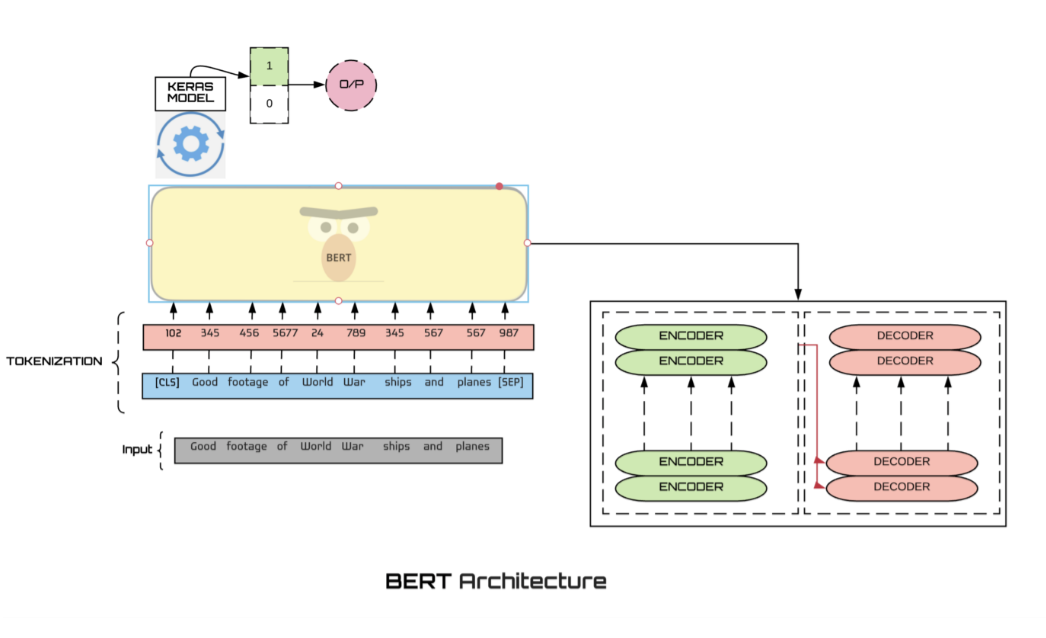

In [13]:
display(Image(filename='bert-architecture.png'))


The total number of trainable parameters is ~110M, just like the BERT paper mentions.
Here’s a brief of various steps in the model:

#### Two inputs: One from word tokens, one from segment-layer
#### These get added, summed over to a third embedding: position embedding, followed by dropout and a layer normalization
 BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed).
#### Following these 12 layers, there are two outputs — one for NSP (Next Sentence Prediction) and one for MLM (Masked Language Modeling)

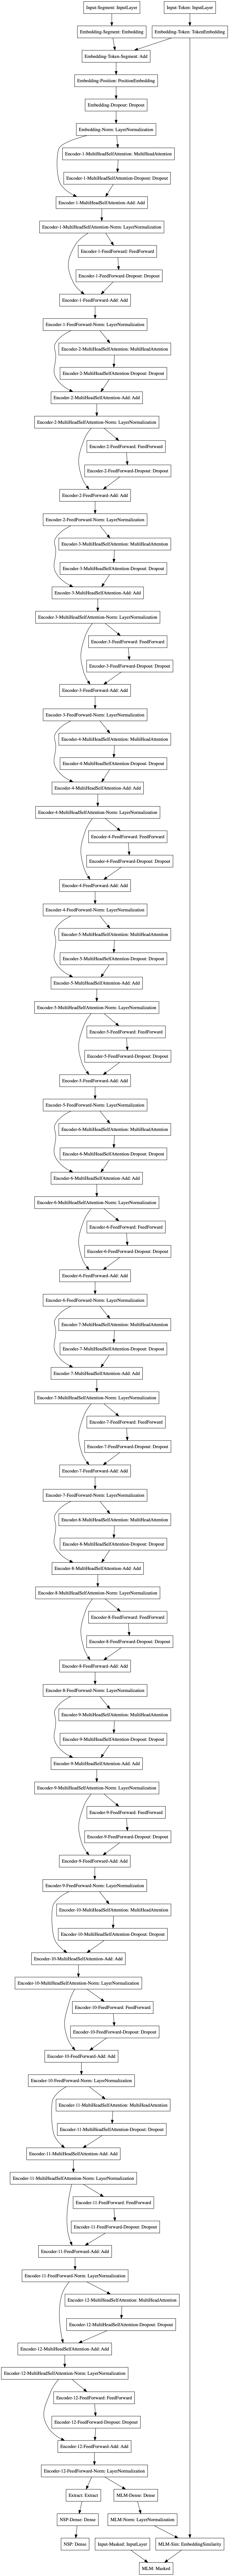

In [14]:
display(Image(filename='bert_layers.png'))

In [15]:
## print model summary  110M trainable params
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

In [16]:
# Extracting token dictionary from vocab of pretrained model to refer

In [17]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)
        

#### Initiating tokenizer

“[CLS]” and “[SEP]” tokens at the beginning and at the end of each sequence. 

As BERT model requests, token “[CLS]” stands for class and has to be placed at the beginning of the input example.
“[SEP]” token is for separating sentences for the next sentence prediction task.


In [18]:
tokenizer = Tokenizer(token_dict)

In [19]:
print(tokenizer.tokenize('unaffable'))

['[CLS]', 'una', '##ffa', '##ble', '[SEP]']


In [20]:
indices, segments = tokenizer.encode('unaffable')
print(indices)  
print(segments)  

[101, 14477, 20961, 3468, 102]
[0, 0, 0, 0, 0]


In [21]:
model.inputs

[<tf.Tensor 'Input-Token:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'Input-Segment:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'Input-Masked:0' shape=(?, 128) dtype=float32>]

In [22]:
#X_train, X_test, y_train, y_test

In [23]:
X_train.values

array(['look like  signed club  never many friend  made friend school friendship faded time  remaining two  well one moved away    used look forward semester old classmate transferred university thought maybe would hang go student patty every rarely even talk  relationship broke apart couple month ago used friend sort  going walk every  feel line someone new   also realized still loved hurt see another man  spend pretty much 20 studying gaming working  couple year older average uni  hard time making friend    yeah  feel like waste life  still young nothing    small silver lining  signed club sort start next year  average age little older least something  hope help make new friend something ',
       'help feel empty know anymore   lost interest thing used make feel happy  always end cry even tho reason',
       'horrible person  think anymore  want happy  want die  feel like  horrible person  push people away  mean people sometimes ducking insecure  shit happened caused  still  friend 

#### Transforming function to convert the Training set into model's input 

In [24]:
indices= []
for example in X_train.values[:80]: 
    ids,segments =tokenizer.encode(example, max_len=SEQ_LEN)
    indices.append(ids)

In [25]:
np.array(indices)

array([[ 101, 2298, 2066, ...,    0,    0,    0],
       [ 101, 2393, 2514, ...,    0,    0,    0],
       [ 101, 9202, 2711, ...,    0,    0,    0],
       ...,
       [ 101, 2521, 2185, ...,    0,    0,    0],
       [ 101, 3066, 2111, ...,    0,    0,    0],
       [ 101, 2441, 3332, ...,    0,    0,    0]])

In [26]:
np.array(indices).shape[0] ,np.array(indices).shape[1]

(80, 128)

In [27]:
[np.array(indices),np.zeros_like(np.array(indices))] # for input-token, segment-token

[array([[ 101, 2298, 2066, ...,    0,    0,    0],
        [ 101, 2393, 2514, ...,    0,    0,    0],
        [ 101, 9202, 2711, ...,    0,    0,    0],
        ...,
        [ 101, 2521, 2185, ...,    0,    0,    0],
        [ 101, 3066, 2111, ...,    0,    0,    0],
        [ 101, 2441, 3332, ...,    0,    0,    0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [28]:
X_train =[np.array(indices),np.zeros_like(np.array(indices))]

In [29]:
y_train = y_train.values[:80]

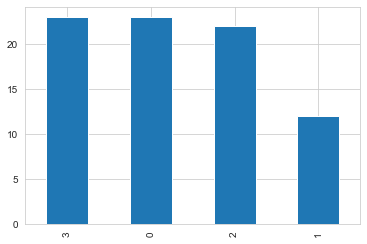

In [30]:
pd.Series(y_train).value_counts().plot(kind = 'bar')

In [31]:
indices= []
for example in X_test.values[:20]: 
    ids,segments =tokenizer.encode(example, max_len=SEQ_LEN)
    indices.append(ids)

In [32]:
X_test = [np.array(indices),np.zeros_like(np.array(indices))]

In [33]:
y_test = y_test.values[:20]

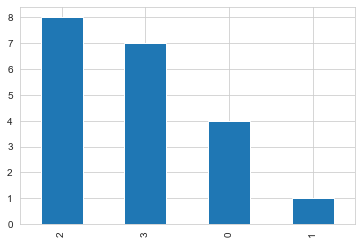

In [34]:
pd.Series(y_test).value_counts().plot(kind = 'bar')

### Fine-tuning 
#### Unlike recent language representation models , BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers.

#### As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task- specific architecture modifications.

##### Our case? Extracting layer from pretrained bert model and adding a layer with softmax for 4 classes of subreddit 


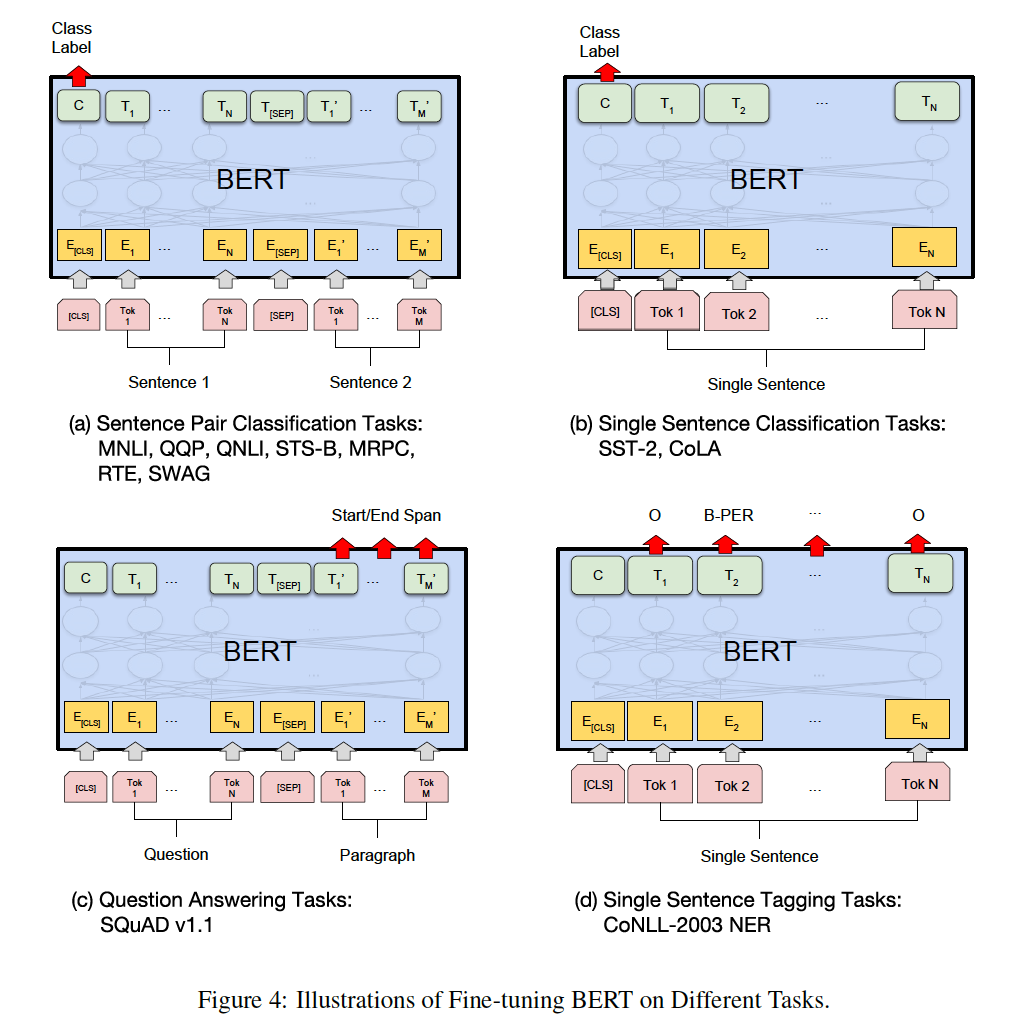

In [35]:
display(Image(filename='fine-tuning-bert.png'))

In [36]:
#input_segments represent the separation.
model.inputs[:2]

[<tf.Tensor 'Input-Token:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'Input-Segment:0' shape=(?, 128) dtype=float32>]

In [44]:
# Assign inputs and output layers for the BERT model
# there are two outputs — one for NSP (Next Sentence Prediction) and one for MLM (Masked Language Modeling)
# For classification NSP-Dense layer will be needed

inputs = model.inputs[:2]
dense = model.get_layer('NSP-Dense').output
#NSP-Dense is the first dense layer after the output of [CLS] token.
outputs = keras.layers.Dense(units=4, activation='softmax')(dense)

'''BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both
left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer
to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, 
without  substantial taskspecific architecture modifications. 
(2019) BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding'''

'BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both\nleft and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer\nto create state-of-the-art models for a wide range of tasks, such as question answering and language inference, \nwithout  substantial taskspecific architecture modifications. \n(2019) BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding'

In [46]:

'''
For sparse_categorical_crossentropy, For class 1 and class 2 targets, in a 5-class classification problem,
the list should be [1,2].  Basically, the targets should be in integer form in order to call sparse_categorical_crossentropy. 
This is called sparse since the target representation requires much less space than one-hot encoding. 
For example, a batch with b targets and k classes needs b * k space to be represented in one-hot, 
whereas a batch with b targets and k classes needs b space to be represented in integer form.

For categorical_crossentropy, for class 1 and class 2 targets, in a 5-class classification problem, 
the list should be [[0,1,0,0,0], [0,0,1,0,0]]. 
Basically, the targets should be in one-hot form in order to call categorical_crossentropy 
representation of the targets are the only difference, 
the results should be the same since they are both calculating categorical crossentropy.
'''

'\nFor sparse_categorical_crossentropy, For class 1 and class 2 targets, in a 5-class classification problem,\nthe list should be [1,2].  Basically, the targets should be in integer form in order to call sparse_categorical_crossentropy. \nThis is called sparse since the target representation requires much less space than one-hot encoding. \nFor example, a batch with b targets and k classes needs b * k space to be represented in one-hot, \nwhereas a batch with b targets and k classes needs b space to be represented in integer form.\n\nFor categorical_crossentropy, for class 1 and class 2 targets, in a 5-class classification problem, \nthe list should be [[0,1,0,0,0], [0,0,1,0,0]]. \nBasically, the targets should be in one-hot form in order to call categorical_crossentropy \nrepresentation of the targets are the only difference, \nthe results should be the same since they are both calculating categorical crossentropy.\n'

In [47]:
#Model Build/Compile
model = keras.models.Model(inputs, outputs)

model.compile(
  RAdam(lr=LR,warmup_proportion=0.1), # We can add up warmup_proportion ex) 0.1
  loss='sparse_categorical_crossentropy',  metrics=['sparse_categorical_accuracy'])

 # keras will choose the maximum value from this array and check if it corresponds to the index of the max value
# in y_pred, should only provide an integer of the true class 
# Categorical Accuracy: It evaluates the index of the maximal true value is equal to the index of the maximal predicted 
#value. you need to specify your target (y) as one-hot encoded vector


#### Optimizer RAdam and why :
Rectified Adam optimizer:

#### A good optimizer trains models fast, but it also prevents them from getting stuck in a local minimum. Rectified Adam is a one of the most recent deep learning model optimizers introduced by a collaboration between members of the University of Illinois, Georgia Tech, and Microsoft Research. 
#### Essentially, they seek to understand why a "warmup" phase is beneficial for scheduling learning rates, and then "identify" the underlying problem to be related to" high variance" and "poor generalization" during the first few batches. 



#### They find that the issue can be remedied by using either a "warmup"  or "low initial learning rate",or by turning off momentum for the first couple of batches. nstead of setting the learning rate alpha as a constant or in a decreasing order, a learning rate warmup strategy sets αt as smaller values in the first few steps, and as more training examples are fed in, the variance stabilizes and the learning rate/momentum can be increased. They therefore proposed a Rectified Adam optimizer that dynamically changes the momentum in a way that hedges against high variance. 



The goal of the Rectified Adam optimizer is :

1) Obtain a more robust/more generalizable deep neural network

2) dynamically changes the learning rate/momentum & hedges against high variance. 

3) To solve the problem of the adaptive learning rate (i.e.,problematically large variance in the early stage), 
   suggest warmup works as a variance reduction technique, 
   and provide both empirical and theoretical evidence to verify our hypothesis


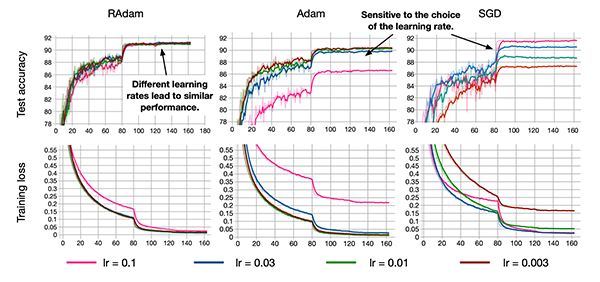

In [48]:
display(Image(filename='rectified_adam.png'))

In [49]:
# Initializing variables. 

## Variable tensors are used when the values require updating within a session. 
### It is the type of tensor that would be used for the weights matrix when creating neural networks, 
### since these values will be updated as the model is being trained.

In [56]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables]
)
sess.run(init_op)

### Begin Training and Validation for 4 epcohs

In [51]:
history= model.fit(
    X_train,
    y_train,
    validation_split = 0.15,
    shuffle =True,
    epochs=4,
    batch_size=BATCH_SIZE,
)

Train on 68 samples, validate on 12 samples
Epoch 1/4


KeyboardInterrupt: 

In [ ]:
# list all data in history
history.history

In [ ]:
model.summary()

#### Plot the history for accuracy of Training/ Validation

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Plot the history for loss of Training/ Validation

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Prediction on Test Data set of 50 example cases

In [ ]:
## Around 60 %

In [ ]:
predicts = model.predict(X_test, verbose=True).argmax(axis=-1)

In [ ]:
print(np.sum(y_test == predicts) / y_test.shape[0])

In [ ]:
#### 0: SuicideWatch
#### 1 : depressed
#### 2 : happy
#### 3 :  selfimprovement

In [ ]:
#  F1 Score is the weighted average of Precision and Recall. Therefore, 
#this score takes both false positives and false negatives into account
#- F1 is usually more useful than accuracy, especially if you have an uneven class distribution. 


In [55]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

precision, recall, fscore, support = score(y_test, predicts)
target_names = ['SuicideWatch', 'depressed', 'happy', 'selfimprovement']
print(classification_report(y_test, predicts, target_names=target_names))
# 'weighted' calculates de F1 score for each class independently but when it adds them together uses a weight 
#that depends on the number of true labels of each class: favouring the majority class.
# 'micro' uses the global number of TP, FN, FP and calculates the F1 directly no favouring any class in particular.
# 'macro average F1 score is the unweighted average of the F1-score over all the classes in the multiclass case.
# It does not take into account the frequency of occurrence of the classes in the evaluation dataset.

f1_score(y_test, predicts, average='weighted')

NameError: name 'predicts' is not defined

In [ ]:
confusion_matrix(y_test, predicts,labels=[0,1,2,3])

#### Practice cases  Comparison with 500 training cases model :  bert-tensorflow vs bert-keras

In [240]:
# [('I am so happy', array([-3.476168  , -3.7458189 , -0.09595221, -3.2981746 ], dtype=float32), 
# 'happy'),
# ('fuck', array([-0.7367987 , -2.458499  , -0.99514765, -2.7162235 ], dtype=float32),
# 'SuicideWatch'),
# ('I feel nice',array([-3.3612282 , -3.5323107 , -0.11635606, -3.0810325 ], dtype=float32),
# 'happy'),
# ('I want to commit a suicide',  array([-0.30930468, -1.9100459 , -2.6896908 , -2.9943867 ], dtype=float32), 
#'SuicideWatch'),
# ('I did self-improvement', array([-3.1551628, -3.093685 , -0.3177928, -1.6912969], dtype=float32),
# 'happy'), --> This case needs to be fixed!!
# ('self-improvement', array([-2.2937117 , -2.275855  , -2.0193448 , -0.40998942], dtype=float32),
# 'selfimprovement'),
# ('I felt happy yesterday but no more, now i want to die', array([-1.4680753 , -3.1400657 , -0.37962782, -3.1644907 ], dtype=float32),
# 'happy'), --> This case needs to be fixed!!  
# ('I feel bad and want to die but I actually overcome this and become positive',array([-0.6128137, -2.0051608, -1.603159 , -2.1014626], dtype=float32),
#'SuicideWatch'), --> This case nes to be fixed!!
#('Absolutely fantastic!',array([-3.527619  , -3.9238014 , -0.09763478, -3.1263125 ], dtype=float32), 
# 'happy')] ''' 

In [237]:
# Encoding subreddit into 'subreddit_categorical_label' -> To use this column in classification modeling
#### 0: SuicideWatch
#### 1 : depressed
#### 2 : happy
#### 3 :  selfimprovement

In [367]:
## Show a positive progress compare to previous model! 

In [364]:
pred_sentences = [
    "I am so happy", #happy
    "fuck", # SuicideWatch
    "I feel nice", #selfimprovement  --> Can be considered as "happy"
    "I want to commit a suicide",#SuicideWatch
    "I did self-improvement", #selfimprovement
    "self-improvement",# selfimprovement
    "I felt happy yesterday but no more, now i want to die", #SuicideWatch 
    "I feel bad and want to die but I actually overcome this and become positive", #SuicideWatch --> Only this case needs to be fixed!
    "Absolutely fantastic!"#happy
]

In [365]:
indices= []
for example in pred_sentences: 
    ids,segments =tokenizer.encode(example, max_len=SEQ_LEN)
    indices.append(ids)

example_x = [np.array(indices),np.zeros_like(np.array(indices))]

In [366]:
model.predict(example_x, verbose=True).argmax(axis=-1)

9/9 [==============================] - 12s 1s/step


array([2, 0, 3, 0, 3, 3, 0, 0, 2])

In [ ]:
###  Experiment

## New training/test split for "Early stopping Functionality" test

In [71]:
seed = 0
X_train, X_test, y_train, y_test = train_test_split(all_subreddit_df_list['title_with_selftext_clean'], all_subreddit_df_list['subreddit_categorical_label'], \
                                                    test_size=0.33, random_state=seed)

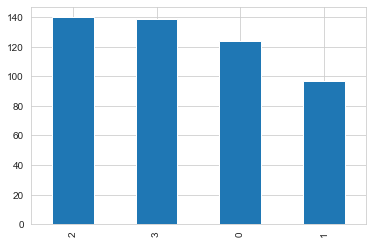

In [376]:
indices= []
for example in X_train.values[:500]: 
    ids,segments =tokenizer.encode(example, max_len=SEQ_LEN)
    indices.append(ids)
X_train =[np.array(indices),np.zeros_like(np.array(indices))]
y_train = y_train.values[:500]
pd.Series(y_train).value_counts().plot(kind = 'bar')


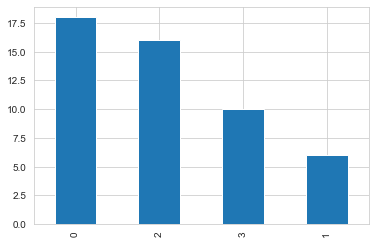

In [377]:
indices= []
for example in X_test.values[:50]: 
    ids,segments =tokenizer.encode(example, max_len=SEQ_LEN)
    indices.append(ids)
X_test = [np.array(indices),np.zeros_like(np.array(indices))]    
y_test = y_test.values[:50]
pd.Series(y_test).value_counts().plot(kind = 'bar')

## Early Stopping : to avoid overfitting in neural network
#### A problem with training neural networks is in the choice of the number of training epochs to use. Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. 
#### Early stopping?  
#### A method that allows you to specify an arbitrarily large number of training epochs and stop training once the model performance stops improving on the "Validation dataset".
This requires that a validation split should be provided to the fit() function and a "EarlyStopping" callback to specify performance measure on which performance will be monitored on validation split. Training will stop when the chosen performance measure stops improving. Once stopped, the "callback" will print the epoch number.

#### Patience argument?  
#### Often, the first sign of no improvement may not be the best time to stop training and this is because the model may get slightly worse before getting much better sometimes. 
We can account for this by adding a delay to the trigger in terms of the number of epochs on which we would like to see no improvement. This can be done by setting the “Patience” argument .The exact amount of patience will vary between models and problems. there a rule of thumb to make it 10% of number of epoch. For example, 1 for 10 epoch.



In [54]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#### We wanted to monitor the validation loss at each epoch and after the validation loss has not improved after two epochs, training is interrupted. However, since we set patience=2, we won’t get the best model, but the model two epochs after the best model.

So, An additional callback is required that will save the best model observed during training for later use. This is the
#### ModelCheckpoint callback.  

In [382]:
#option1 : 
history_new= model.fit(
    X_train,
    y_train,
    validation_split = 0.15,
    shuffle =True,
    epochs=5,
    batch_size=BATCH_SIZE,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose =1),\
                       ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
)


Train on 425 samples, validate on 75 samples
Epoch 1/5
425/425 [==============================] - 4104s 10s/step - loss: 0.3565 - sparse_categorical_accuracy: 0.8729 - val_loss: 0.7956 - val_sparse_categorical_accuracy: 0.6800
Epoch 2/5
425/425 [==============================] - 1971s 5s/step - loss: 0.1933 - sparse_categorical_accuracy: 0.9341 - val_loss: 0.8428 - val_sparse_categorical_accuracy: 0.7333
Epoch 3/5
425/425 [==============================] - 1942s 5s/step - loss: 0.1010 - sparse_categorical_accuracy: 0.9741 - val_loss: 1.1433 - val_sparse_categorical_accuracy: 0.6800
Epoch 00003: early stopping


In [383]:
# list all data in history
history_new.history

{'val_loss': [0.795638378461202, 0.8428328784306844, 1.143257573445638],
 'val_sparse_categorical_accuracy': [0.6800000023841858,
  0.7333333353201549,
  0.6799999984105428],
 'loss': [0.3564748824343962, 0.19333129896837123, 0.10104309039957383],
 'sparse_categorical_accuracy': [0.8729411764705882,
  0.9341176470588235,
  0.9741176471990698]}

In [384]:
# summarize history for loss

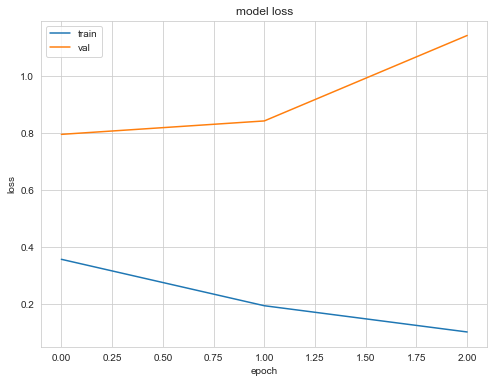

In [387]:
plt.figure(figsize=(8,6))
plt.plot(history_new.history['loss'])
plt.plot(history_new.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# summarize history for accuracy

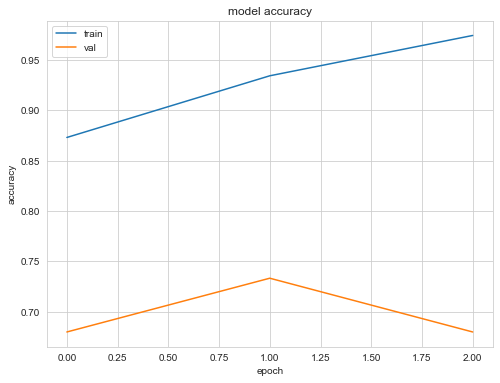

In [386]:
plt.figure(figsize=(8,6))
plt.plot(history_new.history['sparse_categorical_accuracy'])
plt.plot(history_new.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Load the saved best model

In [57]:
from keras.models import load_model
from keras_bert import get_custom_objects

In [415]:
'''from keras_bert.layers import TokenEmbedding
from keras_pos_embd import PositionEmbedding
from keras_layer_normalization import LayerNormalization
from keras_multi_head import MultiHeadAttention
from keras_position_wise_feed_forward import FeedForward
from keras_transformer import gelu
CUSTOM_OBJECTS={'TokenEmbedding':TokenEmbedding, 
'PositionEmbedding': PositionEmbedding,
'LayerNormalization': LayerNormalization,
'MultiHeadAttention': MultiHeadAttention,
'FeedForward': FeedForward,
'gelu': gelu}'''

"from keras_bert.layers import TokenEmbedding\nfrom keras_pos_embd import PositionEmbedding\nfrom keras_layer_normalization import LayerNormalization\nfrom keras_multi_head import MultiHeadAttention\nfrom keras_position_wise_feed_forward import FeedForward\nfrom keras_transformer import gelu\nCUSTOM_OBJECTS={'TokenEmbedding':TokenEmbedding, \n'PositionEmbedding': PositionEmbedding,\n'LayerNormalization': LayerNormalization,\n'MultiHeadAttention': MultiHeadAttention,\n'FeedForward': FeedForward,\n'gelu': gelu}"

### Need to update our custom objects for loading our customed bert-model 

In [58]:
custom_objects = get_custom_objects()
my_objects = {'RAdam': RAdam}
custom_objects.update(my_objects)

In [ ]:
## Successfully Load our best model!

In [414]:
saved_model = keras.models.load_model('best_model.h5', custom_objects=custom_objects)

#### Prediction on Newly Assigned 50 Test Cases 
#### & Previous vs Saved Model Performance Comparison

In [419]:
predicts_new = saved_model.predict(X_test, verbose=True).argmax(axis=-1)
print(np.sum(y_test == predicts_new) / y_test.shape[0])

50/50 [==============================] - 54s 1s/step
0.74


In [422]:
predicts_old = model.predict(X_test, verbose=True).argmax(axis=-1)
print(np.sum(y_test == predicts_old) / y_test.shape[0])

50/50 [==============================] - 60s 1s/step
0.74


In [430]:
precision, recall, fscore, support = score(y_test, predicts_old)
target_names = ['SuicideWatch', 'depressed', 'happy', 'selfimprovement']
print(classification_report(y_test, predicts_old, target_names=target_names))

# 'weighted' calculates de F1 score for each class independently but when it adds them together uses a weight 
# that depends on the number of true labels of each class: favouring the majority class.

# 'micro' uses the global number of TP, FN, FP and calculates the F1 directly no favouring any class in particular.
# 'macro average F1 score is the unweighted average of the F1-score over all the classes in the multiclass case.
# It does not take into account the frequency of occurrence of the classes in the evaluation dataset.

f1_score(y_test, predicts_old, average='weighted')

                 precision    recall  f1-score   support

   SuicideWatch       1.00      0.56      0.71        18
      depressed       0.43      0.50      0.46         6
          happy       0.83      0.94      0.88        16
selfimprovement       0.60      0.90      0.72        10

       accuracy                           0.74        50
      macro avg       0.72      0.72      0.69        50
   weighted avg       0.80      0.74      0.74        50



0.7388804137039432

In [431]:
precision, recall, fscore, support = score(y_test, predicts_new)
target_names = ['SuicideWatch', 'depressed', 'happy', 'selfimprovement']
print(classification_report(y_test, predicts_new, target_names=target_names))
f1_score(y_test, predicts_new, average='weighted')

                 precision    recall  f1-score   support

   SuicideWatch       0.92      0.61      0.73        18
      depressed       0.33      0.67      0.44         6
          happy       0.83      0.94      0.88        16
selfimprovement       0.88      0.70      0.78        10

       accuracy                           0.74        50
      macro avg       0.74      0.73      0.71        50
   weighted avg       0.81      0.74      0.76        50



0.7552418300653595

In [ ]:
### Confusion Matrix comparison

In [425]:
confusion_matrix(y_test, predicts_old,labels=[0,1,2,3])

array([[10,  3,  1,  4],
       [ 0,  3,  1,  2],
       [ 0,  1, 15,  0],
       [ 0,  0,  1,  9]])

In [426]:
confusion_matrix(y_test, predicts_new,labels=[0,1,2,3])

array([[11,  6,  1,  0],
       [ 1,  4,  0,  1],
       [ 0,  1, 15,  0],
       [ 0,  1,  2,  7]])

# Same example case model prediction comparison 

## Case1 : Bert-tensorflow - previous version (Traing/val with 500 cases)
## - Accuracy : 60-63%

In [481]:
'''[('I am so happy', array([-3.476168  , -3.7458189 , -0.09595221, -3.2981746 ], dtype=float32), 
# 'happy'),
# ('fuck', array([-0.7367987 , -2.458499  , -0.99514765, -2.7162235 ], dtype=float32),
# 'SuicideWatch'),
# ('I feel nice',array([-3.3612282 , -3.5323107 , -0.11635606, -3.0810325 ], dtype=float32),
# 'happy'),
# ('I want to commit a suicide',  array([-0.30930468, -1.9100459 , -2.6896908 , -2.9943867 ], dtype=float32), 
#'SuicideWatch'),

# ('I did self-improvement', array([-3.1551628, -3.093685 , -0.3177928, -1.6912969], dtype=float32),
# 'happy'), --> This case needs to be fixed!!

# ('self-improvement', array([-2.2937117 , -2.275855  , -2.0193448 , -0.40998942], dtype=float32),
# 'selfimprovement'),

# ('I felt happy yesterday but no more, now i want to die', array([-1.4680753 , -3.1400657 , -0.37962782, -3.1644907 ], dtype=float32),
# 'happy'), --> This case needs to be fixed!!  

# ('I feel bad and want to die but I actually overcome this and become positive',array([-0.6128137, -2.0051608, -1.603159 , -2.1014626], dtype=float32),
#'SuicideWatch'), --> This case might need to be fixed!!

#('Absolutely fantastic!',array([-3.527619  , -3.9238014 , -0.09763478, -3.1263125 ], dtype=float32), 
# 'happy')] ''' 

"[('I am so happy', array([-3.476168  , -3.7458189 , -0.09595221, -3.2981746 ], dtype=float32), \n# 'happy'),\n# ('fuck', array([-0.7367987 , -2.458499  , -0.99514765, -2.7162235 ], dtype=float32),\n# 'SuicideWatch'),\n# ('I feel nice',array([-3.3612282 , -3.5323107 , -0.11635606, -3.0810325 ], dtype=float32),\n# 'happy'),\n# ('I want to commit a suicide',  array([-0.30930468, -1.9100459 , -2.6896908 , -2.9943867 ], dtype=float32), \n#'SuicideWatch'),\n\n# ('I did self-improvement', array([-3.1551628, -3.093685 , -0.3177928, -1.6912969], dtype=float32),\n# 'happy'), --> This case needs to be fixed!!\n\n# ('self-improvement', array([-2.2937117 , -2.275855  , -2.0193448 , -0.40998942], dtype=float32),\n# 'selfimprovement'),\n\n# ('I felt happy yesterday but no more, now i want to die', array([-1.4680753 , -3.1400657 , -0.37962782, -3.1644907 ], dtype=float32),\n# 'happy'), --> This case needs to be fixed!!  \n\n# ('I feel bad and want to die but I actually overcome this and become positi

## Case2 : Bert-without Stopping (Traing/val with 500 cases) - Accuracy : 60-73%

In [440]:
'''pred_sentences = [
    "I am so happy", #happy
    "fuck", # SuicideWatch
    "I feel nice", #selfimprovement  --> Can be considered as "happy"
    "I want to commit a suicide",#SuicideWatch
    "I did self-improvement", #selfimprovement
    "self-improvement",# selfimprovement
    "I felt happy yesterday but no more, now i want to die", #SuicideWatch 
    "I feel bad and want to die but I actually overcome this and become positive",
    #SuicideWatch --> This case needs to be fixed!
    "Absolutely fantastic!"#happy
]'''

'pred_sentences = [\n    "I am so happy", #happy\n    "fuck", # SuicideWatch\n    "I feel nice", #selfimprovement  --> Can be considered as "happy"\n    "I want to commit a suicide",#SuicideWatch\n    "I did self-improvement", #selfimprovement\n    "self-improvement",# selfimprovement\n    "I felt happy yesterday but no more, now i want to die", #SuicideWatch \n    "I feel bad and want to die but I actually overcome this and become positive", #SuicideWatch --> Only this case needs to be fixed!\n    "Absolutely fantastic!"#happy\n]'

## Case3 : Bert-with EarlyStopping - prevent over/under-fitting model 
## (Traing/val with 500 cases) - Accuracy : 73%

In [432]:
pred_sentences = [
    "I am so happy", #happy
    "fuck", # SuicideWatch
    "I feel nice", #happy --> Nice improvement case of saved best model compare to previous 4 epoch model
    "I want to commit a suicide",#SuicideWatch
    "I did self-improvement", #selfimprovement
    "self-improvement",# selfimprovement
    "I felt happy yesterday but no more, now i want to die", #SuicideWatch 
    
    "I feel bad and want to die but I actually overcome this and become positive", 
    #SuicideWatch --> Only this case might need to be fixed! 
    
    "Absolutely fantastic!"#happy
]

In [417]:
indices= []
for example in pred_sentences: 
    ids,segments =tokenizer.encode(example, max_len=SEQ_LEN)
    indices.append(ids)
example_x = [np.array(indices),np.zeros_like(np.array(indices))]
saved_model.predict(example_x, verbose=True).argmax(axis=-1)

9/9 [==============================] - 33s 4s/step


array([2, 0, 2, 0, 3, 3, 0, 0, 2])

## Case4 : Bert-with EarlyStopping - prevent over/under-fitting model 
## (Traing/val with 1000 cases)  - Accuracy : 77%

In [ ]:
pred_sentences = [
    "I am so happy", #happy
    "fuck", # SuicideWatch
    "I feel nice", #happy 
    "I want to commit a suicide",#SuicideWatch
    "I did self-improvement", #selfimprovement
    "self-improvement",# selfimprovement
    "I felt happy yesterday but no more, now i want to die", #SuicideWatch 
    
    "I feel bad and want to die but I actually overcome this and become happy", 
    #SuicideWatch --> Only this case might need to be fixed! 
    
    "Absolutely fantastic!"#happy
]

# Final training/test split for 1000 training case model test

In [74]:
seed = 10
X_train, X_test, y_train, y_test = train_test_split(all_subreddit_df_list['title_with_selftext_clean'], all_subreddit_df_list['subreddit_categorical_label'], \
                                                    test_size=0.33, random_state=seed)

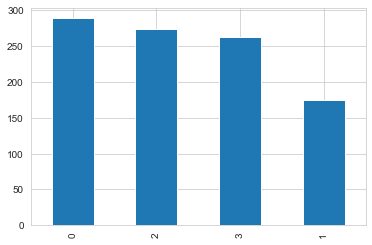

In [452]:
indices= []
for example in X_train.values[:1000]: 
    ids,segments =tokenizer.encode(example, max_len=SEQ_LEN)
    indices.append(ids)
X_train =[np.array(indices),np.zeros_like(np.array(indices))]
y_train = y_train.values[:1000]
pd.Series(y_train).value_counts().plot(kind = 'bar')


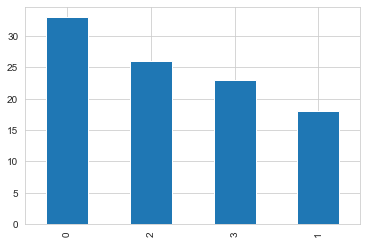

In [453]:
indices= []
for example in X_test.values[:100]: 
    ids,segments =tokenizer.encode(example, max_len=SEQ_LEN)
    indices.append(ids)
X_test = [np.array(indices),np.zeros_like(np.array(indices))]    
y_test = y_test.values[:100]
pd.Series(y_test).value_counts().plot(kind = 'bar')

In [460]:
history_new1= model.fit(
    X_train,
    y_train,
    validation_split = 0.15,
    shuffle =True,
    epochs=5,
    batch_size=BATCH_SIZE,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose =1),\
                       ModelCheckpoint(filepath='best_model_1000.h5', monitor='val_loss', save_best_only=True)]
)

Train on 850 samples, validate on 150 samples
Epoch 1/5
850/850 [==============================] - 5067s 6s/step - loss: 0.7585 - sparse_categorical_accuracy: 0.7106 - val_loss: 0.6816 - val_sparse_categorical_accuracy: 0.7267
Epoch 2/5
850/850 [==============================] - 5106s 6s/step - loss: 0.4044 - sparse_categorical_accuracy: 0.8612 - val_loss: 0.7413 - val_sparse_categorical_accuracy: 0.7267
Epoch 3/5
850/850 [==============================] - 4640s 5s/step - loss: 0.2135 - sparse_categorical_accuracy: 0.9259 - val_loss: 0.7497 - val_sparse_categorical_accuracy: 0.7467
Epoch 00003: early stopping


In [ ]:
# summarize history for loss

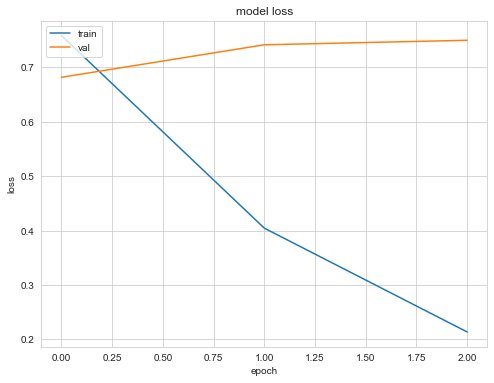

In [461]:
plt.figure(figsize=(8,6))
plt.plot(history_new1.history['loss'])
plt.plot(history_new1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# summarize history for accuracy

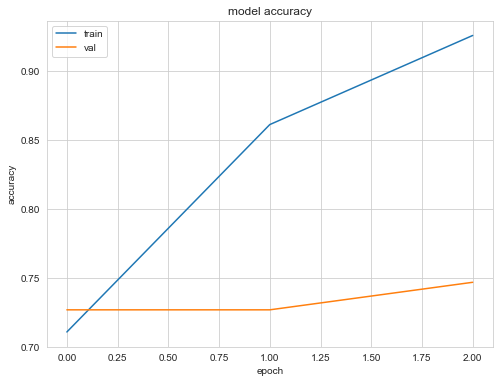

In [462]:
plt.figure(figsize=(8,6))
plt.plot(history_new1.history['sparse_categorical_accuracy'])
plt.plot(history_new1.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Test accuracy for 100 cases : 77%

## Load the saved best model

In [59]:
saved_model = keras.models.load_model('best_model_1000.h5', custom_objects=custom_objects)

In [65]:
predicts_new1 = saved_model.predict(X_test, verbose=True).argmax(axis=-1)
print(np.sum(y_test == predicts_new1) / y_test.shape[0])

20/20 [==============================] - 22s 1s/step
0.75


In [64]:
X_test

[array([[  101,  2028,  2095, ...,  2250,  5948,   102],
        [  101,  4531, 23563, ...,     0,     0,     0],
        [  101,  3784,  2767, ...,  2507,  2775,   102],
        ...,
        [  101,  2729,  2500, ...,     0,     0,     0],
        [  101,  6015, 15415, ...,     0,     0,     0],
        [  101,  5223,  2166, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [61]:
predicts_new2 = saved_model.predict(X_test, verbose=True)

print(predicts_new2)

20/20 [==============================] - 33s 2s/step
[[0.03527543 0.26194155 0.20935631 0.49342662]
 [0.02723355 0.2807366  0.47712025 0.21490964]
 [0.7947106  0.15148175 0.0243274  0.02948031]
 [0.34020463 0.49601713 0.12806453 0.03571362]
 [0.00169614 0.00321    0.99318016 0.00191379]
 [0.16109563 0.05243589 0.61648107 0.16998741]
 [0.02308971 0.06504871 0.00709997 0.9047617 ]
 [0.00629797 0.03278215 0.05962687 0.901293  ]
 [0.0059758  0.00268108 0.98430276 0.00704043]
 [0.06527594 0.1573432  0.01927136 0.75810957]
 [0.08122469 0.15772592 0.02084013 0.7402093 ]
 [0.09587923 0.6421983  0.09105945 0.17086309]
 [0.00479046 0.00919049 0.4599954  0.5260236 ]
 [0.01759615 0.01104398 0.05416393 0.9171959 ]
 [0.09261854 0.031769   0.83784497 0.0377674 ]
 [0.2885918  0.4238396  0.2245797  0.06298891]
 [0.00452011 0.00835632 0.9841249  0.00299859]
 [0.43888733 0.31445697 0.15206562 0.09459008]
 [0.00328253 0.00452626 0.988898   0.00329322]
 [0.7913912  0.17492792 0.01897778 0.01470315]]


In [63]:
predicts_new3 = predicts_new2.argmax(axis=-1)
print(predicts_new3)

[3 2 0 1 2 2 3 3 2 3 3 1 3 3 2 1 2 0 2 0]


In [66]:
precision, recall, fscore, support = score(y_test, predicts_new1)
target_names = ['SuicideWatch', 'depressed', 'happy', 'selfimprovement']
print(classification_report(y_test, predicts_new1, target_names=target_names))

# 'weighted' calculates de F1 score for each class independently but when it adds them together uses a weight 
# that depends on the number of true labels of each class: favouring the majority class.

# 'micro' uses the global number of TP, FN, FP and calculates the F1 directly no favouring any class in particular.
# 'macro average F1 score is the unweighted average of the F1-score over all the classes in the multiclass case.
# It does not take into account the frequency of occurrence of the classes in the evaluation dataset.

f1_score(y_test, predicts_new1, average='weighted')

                 precision    recall  f1-score   support

   SuicideWatch       0.67      0.50      0.57         4
      depressed       0.33      1.00      0.50         1
          happy       0.86      0.75      0.80         8
selfimprovement       0.86      0.86      0.86         7

       accuracy                           0.75        20
      macro avg       0.68      0.78      0.68        20
   weighted avg       0.79      0.75      0.76        20



0.7592857142857142

In [67]:
pred_sentences = [
    "I am so happy", #happy
    "fuck", # SuicideWatch
    "I feel nice", #happy 
    "I want to commit a suicide",#SuicideWatch
    "I did self-improvement", #selfimprovement
    "self-improvement",# selfimprovement
    "I felt happy yesterday but no more, now i want to die", #SuicideWatch 
    
    "I feel bad and want to die but I actually overcome this and become happy", 
    #happy
    
    "Absolutely fantastic!"#happy
]

In [68]:
indices= []
for example in pred_sentences: 
    ids,segments =tokenizer.encode(example, max_len=SEQ_LEN)
    indices.append(ids)
example_x = [np.array(indices),np.zeros_like(np.array(indices))]
proba = saved_model.predict(example_x, verbose=True)# .argmax(axis=-1)
print(proba)
proba.argmax(axis=-1)

9/9 [==============================] - 9s 1s/step
[[0.00394031 0.00349309 0.9897524  0.00281419]
 [0.68036234 0.13592505 0.15284994 0.03086267]
 [0.02950726 0.2260452  0.6851705  0.05927701]
 [0.6907735  0.17485973 0.10565516 0.02871159]
 [0.0070367  0.01061606 0.06917993 0.9131673 ]
 [0.00421464 0.00339513 0.01493568 0.97745454]
 [0.674467   0.08350355 0.21879633 0.02323316]
 [0.07529469 0.01747408 0.89168835 0.0155429 ]
 [0.01533212 0.00613171 0.9707492  0.00778698]]


array([2, 0, 2, 0, 3, 3, 0, 2, 2])

In [69]:
pred_sentences= [
    "Goodbye reddit . I came on here to say thank you so much . You guys are the only friends I actually had . Without you guys I wouldn’t be here \
    . I didn’t want to leave selfishly because I appreciate all the support you guys have given me . I’ve held on for you guys . I’m so sorry but it’s over . \
    This is my goodbye . I want to let everyone on this sub know that you all are such amazing people . The people who are bringing you down or the \
    situations your going through will be overcame with god and love from the people who truly support you. Your beautiful. Your handsome . \
    Your worth so much . Do not let words define you, define yourself . T R I G G E R W A R N I N G As of for me , I should listen to my own advice . \
    But I can’t do it anymore . I’m suffering . The smile is fake , it’s always been . The words I’ve been told cut deeper then the blades, and the scars represent someone . \
    It’s like I’m drowning and the lifesaver isn’t there . I’m so exhausted . I’m a child . Half of the words you’ve read so far I’m sure wasn’t expected for a thirteen year old .\
    I can’t take it anymore . I’m everyone’s anchor but when it’s me nobody’s there . the hints I’ve tried to give that i simply just needed help. it’s like i’m trapped in my own head \
    . i have no friends , nobody texts me , there’s only 3 which require me texting first then i get used to deal with issues when I can barely help myself . i’ve been told to kill myself ,\
    that nobody would care if i’m gone , that nobody cares about me . i’ve been called slow and retarded by my own mother . i’ve been put down all my life . \
    my mom threatens to call the cops if she doesn’t want me there , my dad left my life , i live in fear of guys because every boyfriend my mom has had molested me or their son .\
    in school, the only friend i thought I had told me nobody would ever want me and if they did it would just be for my body . i held the tears in as i cried my eyes out when I got home .\
    my cousin tried to molest me , this is all too much for me . the amount of therapy can’t take it back . i don’t even go to therapy . my mom met a new guy not too long ago and he’s \
    said so much hurtful things to me that I’m not going to say because they are so disgusting . i can’t take it anymore . i’m sorry. nothing you say can make me rethink my mind .\
    i’ve tried , them tried again, then tried again, then tried again, then kept falling deeper and deeper until living feels like the real definition of what hell is. I had so many dreams .\
    I wanted to be a actor . I would practice , I like watching movies and seeing how well they play the role and take notes from it , and i missed my last audition so i couldn’t make it .\
    i’m always into being a lawyer , which somewhat got me inspired into acting. i’m 13 but on the inside i’m not . I have a XR which I bought with my own money, I payed my own bill \
    which I have to pay next month and I’m so stressed out because I thought this was the parent’s responsibility. I’m so stressed out. it’s not that she couldn’t afford it she said she wants \
    to pay her bill only and not mine . and she told me to buy my own phone . i also will be purchasing my own school supply’s which i’ll make the money by selling my belongs, or in more specific terms , \
    would’ve since i’ll be dead . i sometimes feel so strong but yet so small . so pathetic . so worthless . i have no friends . the only friend I did have raped me . \
    life isn’t fun. god , i’m so sorry . you gave me so much strength but sadly the bones of it were broken .goodbye reddit . goodbye world . \
    words can’t save me because those are what killed me . so much possibility . but i’ll be dead when everyone reads this . \
    my hands feel stiff i can’t barely type this , just please don’t let your life go downhill like mines . bye . -j"
]

In [70]:
indices= []
for example in pred_sentences: 
    ids,segments =tokenizer.encode(example, max_len=SEQ_LEN)
    indices.append(ids)
example_x = [np.array(indices),np.zeros_like(np.array(indices))]
proba = saved_model.predict(example_x, verbose=True)# .argmax(axis=-1)
print(proba)
proba.argmax(axis=-1)

1/1 [==============================] - 2s 2s/step
[[0.06534129 0.01173843 0.8909854  0.03193486]]


array([2])

In [88]:
for i,j in zip(X_test[:10],y_test[:10]):
    print (i, j)

asian parent friend always comment appearance  hate never liked body  advice self improvement   asian parent friend always comment weight  darker skin considered pretty traditional asian beauty standard   went phase trying become paler staying indoors  work gained weight moving around much   unhealthy connection food  take diet pill try lose weight  hate way look  hate shoulder leg stomach big calf cheek snack  considered chubby american standard definitely heavy set asian   insecure really want grow become comfortable skin  suggestion keeping consistent lifestyle routine self care advice  3
seem actively search way suffer  diagnosed anything feel dirty posting  dunno man  brain seems actively hunt way sad shit  like part brain actively trying pull 1
fuckin mental state declining life getting shittier shittier  probably gonna die young commit suicide  everyone fuckin inferior piece shit act fuckin better  fuckin job due coronavirus  one fuckin care  money  one nothing live  probably fu

In [91]:
 X_test[0]

'miserable cloudy day might sound stupid  think weather really affect mood  maybe falsely overly externalizing sadness  think least finding factor might culprit minimizes pain '

In [92]:
X_test[0]

'miserable cloudy day might sound stupid  think weather really affect mood  maybe falsely overly externalizing sadness  think least finding factor might culprit minimizes pain '

In [103]:
list(X_test[:1])

['asian parent friend always comment appearance  hate never liked body  advice self improvement   asian parent friend always comment weight  darker skin considered pretty traditional asian beauty standard   went phase trying become paler staying indoors  work gained weight moving around much   unhealthy connection food  take diet pill try lose weight  hate way look  hate shoulder leg stomach big calf cheek snack  considered chubby american standard definitely heavy set asian   insecure really want grow become comfortable skin  suggestion keeping consistent lifestyle routine self care advice ']

In [104]:
pred_sentences= list(X_test[:1])

In [105]:
indices= []
for example in pred_sentences: 
    ids,segments =tokenizer.encode(example, max_len=SEQ_LEN)
    indices.append(ids)
example_x = [np.array(indices),np.zeros_like(np.array(indices))]
proba = saved_model.predict(example_x, verbose=True)
print(proba)
proba.argmax(axis=-1)

1/1 [==============================] - 1s 1s/step
[[0.01871463 0.03183656 0.01346385 0.9359851 ]]


array([3])

## Google TPU model

#### Earlystopping other option using "Training accuracy" treshold : 

In [ ]:
#option2:
#stop training using callback
#https://towardsdatascience.com/neural-network-with-tensorflow-how-to-stop-training-using-callback-5c8d575c18a9

# Implement callback function to stop training
# when accuracy reaches ACCURACY_THRESHOLD
ACCURACY_THRESHOLD = 0.95

class myCallback(atf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > ACCURACY_THRESHOLD):
            print("\n\n Training Reached %2.2f%% accuracy, \
            so now we stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()

# and then
model.fit(x_train, y_train, epochs=5, callbacks=[callbacks])



In [ ]:
## one possible consideration for next_step 

In [ ]:
''' 
We can also build our model's layer with bert_layer in Keras -> we can try this approach 
model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(max_seq_length,), dtype='int32', name='input_ids'),
        bert_layer,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(classes, activation=tf.nn.softmax)
    ])

    model.build(input_shape=(None, max_seq_length))
    '''

In [ ]:
#<Reference>
#https://blog.ekbana.com/fine-tuning-bert-for-text-classification-20news-group-classification-53a55dc09738
#https://colab.research.google.com/drive/1YSfscbb-g92m1vkYxY4IOVMWMfgfLLJDe